In [1]:
import os, shutil, random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import timm
from sklearn.manifold import TSNE


In [2]:
# ============================
# 1) Paths & Hyperparameters
# ============================
root_dir = "/kaggle/input/malimg-original/malimg_paper_dataset_imgs"
working_dir = "/kaggle/working/Malimg_split_vit"

batch_size = 128
num_epochs = 25   # longer training
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# ============================
# 2) Split Dataset (70/15/15)
# ============================
def split_dataset(root_dir, working_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if os.path.exists(working_dir):
        shutil.rmtree(working_dir)
    os.makedirs(working_dir)

    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = os.listdir(cls_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        splits = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split, files in splits.items():
            split_dir = os.path.join(working_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(cls_path, f), os.path.join(split_dir, f))

split_dataset(root_dir, working_dir)


In [4]:
# ============================
# 3) Transforms & Datasets
# ============================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  #  Grayscale → RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ✅ Grayscale → RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(os.path.join(working_dir, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(working_dir, "val"), transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(working_dir, "test"), transform=test_transform)

# ============================
# WeightedRandomSampler for Imbalance
# ============================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weights = [class_weights[t] for t in train_dataset.targets]

sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes


In [5]:
# ============================
# 4) Build ViT Model
# ============================
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(class_names))
model.to(device)

# Weighted CrossEntropyLoss
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [6]:
# ============================
# 5) Training Loop
# ============================
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    scheduler.step()  # update learning rate

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/25 | Train Loss: 0.6293, Train Acc: 74.69% | Val Loss: 0.3816, Val Acc: 86.54%
Epoch 2/25 | Train Loss: 0.1202, Train Acc: 92.13% | Val Loss: 0.2529, Val Acc: 87.62%
Epoch 3/25 | Train Loss: 0.0749, Train Acc: 94.64% | Val Loss: 0.2059, Val Acc: 89.06%
Epoch 4/25 | Train Loss: 0.0693, Train Acc: 95.13% | Val Loss: 0.3522, Val Acc: 90.28%
Epoch 5/25 | Train Loss: 0.0569, Train Acc: 94.71% | Val Loss: 0.3525, Val Acc: 88.98%
Epoch 6/25 | Train Loss: 0.0735, Train Acc: 94.33% | Val Loss: 0.6234, Val Acc: 80.49%
Epoch 7/25 | Train Loss: 0.0483, Train Acc: 95.04% | Val Loss: 0.3073, Val Acc: 90.14%
Epoch 8/25 | Train Loss: 0.0513, Train Acc: 95.28% | Val Loss: 0.3193, Val Acc: 90.50%
Epoch 9/25 | Train Loss: 0.0473, Train Acc: 95.68% | Val Loss: 0.2900, Val Acc: 90.35%
Epoch 10/25 | Train Loss: 0.0459, Train Acc: 95.34% | Val Loss: 0.2729, Val Acc: 90.64%
Epoch 11/25 | Train Loss: 0.0278, Train Acc: 95.96% | Val Loss: 0.2550, Val Acc: 90.64%
Epoch 12/25 | Train Loss: 0.0266, Train A

In [7]:
# ============================
# 6) Evaluation on Test Set
# ============================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report (Macro-F1):")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print("Macro F1:", f1_score(all_labels, all_preds, average="macro"))


Classification Report (Macro-F1):
                precision    recall  f1-score   support

     Adialer.C     1.0000    1.0000    1.0000        19
     Agent.FYI     1.0000    1.0000    1.0000        18
     Allaple.A     0.9977    1.0000    0.9989       443
     Allaple.L     1.0000    1.0000    1.0000       240
 Alueron.gen!J     1.0000    1.0000    1.0000        31
     Autorun.K     0.1241    1.0000    0.2208        17
       C2LOP.P     0.8800    0.9565    0.9167        23
   C2LOP.gen!g     1.0000    0.9333    0.9655        30
Dialplatform.B     1.0000    1.0000    1.0000        28
     Dontovo.A     1.0000    1.0000    1.0000        25
      Fakerean     1.0000    1.0000    1.0000        58
 Instantaccess     1.0000    0.9848    0.9924        66
    Lolyda.AA1     0.9706    1.0000    0.9851        33
    Lolyda.AA2     0.9655    0.9655    0.9655        29
    Lolyda.AA3     1.0000    1.0000    1.0000        19
     Lolyda.AT     1.0000    1.0000    1.0000        25
   Malex.gen!

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


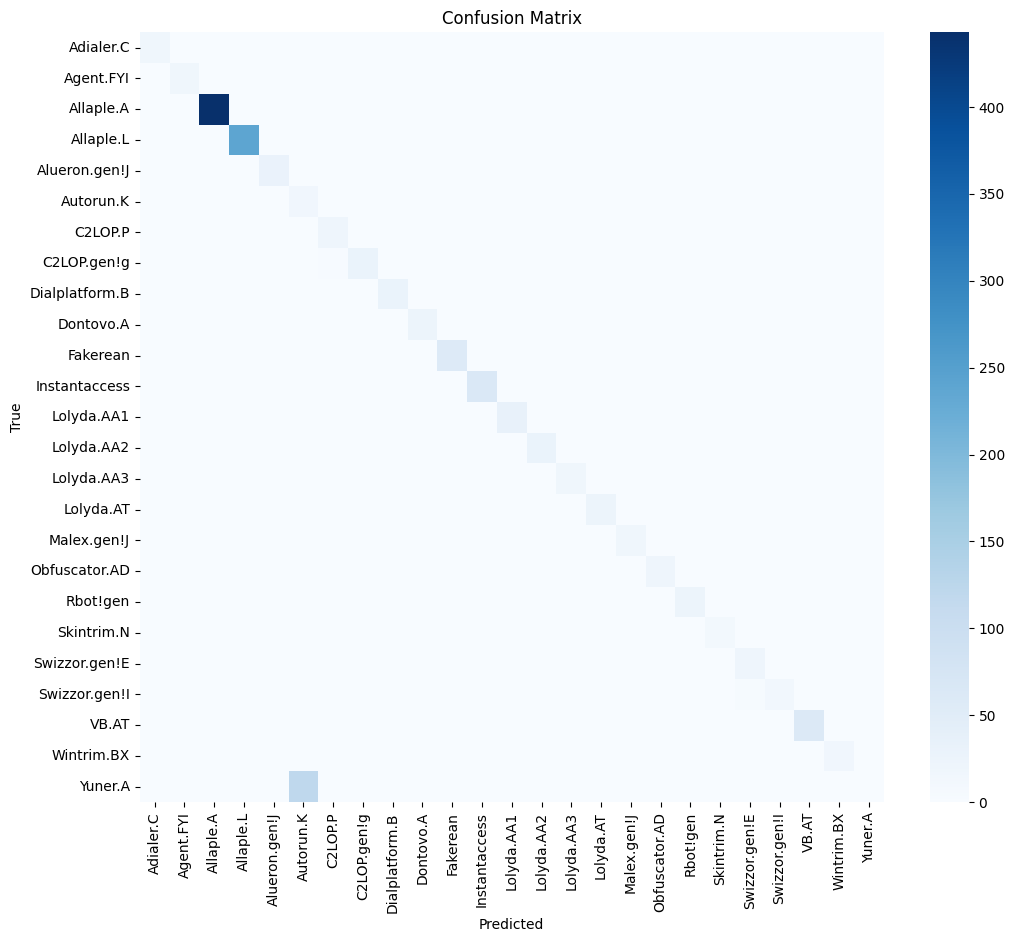

In [8]:
# ============================
# 7) Confusion Matrix
# ============================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:
# ============================
# 8) Feature Extraction for t-SNE (using CLS token)
# ============================
features, labels_list = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = model.forward_features(imgs)   # shape: [batch, seq_len, hidden_dim]
        cls_feats = feats[:, 0, :]             # take CLS token only
        features.append(cls_feats.cpu().numpy())
        labels_list.extend(labels.numpy())

features = np.concatenate(features, axis=0)   # shape: [N, hidden_dim]
labels_list = np.array(labels_list)



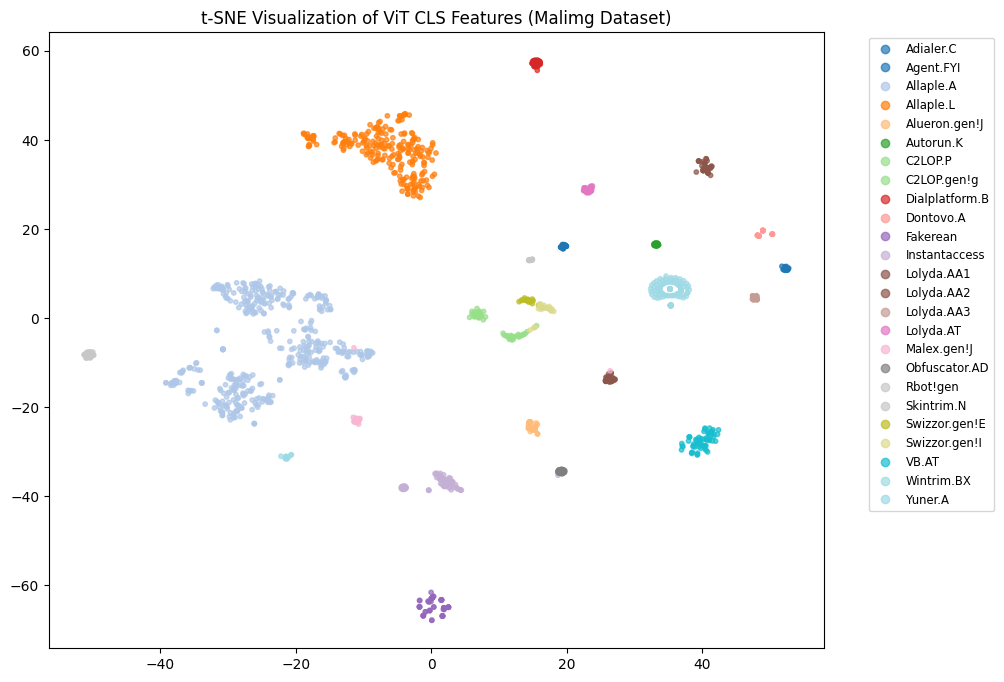

In [10]:
# ============================
# 9) t-SNE Visualization
# ============================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_iter=1000)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10,8))
scatter = plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels_list, cmap="tab20", s=10, alpha=0.7)
handles, _ = scatter.legend_elements(num=len(class_names))
plt.legend(handles, class_names, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
plt.title("t-SNE Visualization of ViT CLS Features (Malimg Dataset)")
plt.show()
